# Görsel Soru Cevaplama - Demo

Bu çalışma dosyası önceden eğitilmiş CNN-LSTM modellerinin ağırlıkları kullanılarak gerçekleştirilmiş, Görsel Soru Cevaplama görevi için hazırlanmış bir demo uygulamasıdır.

Görsel soru cevaplama ile ilgili anlatım ve bu görev için sıklıkla kullanılan veri kümeleri hakkında detaylı bilgi edinmek için **["Çok Gören Mi Bilir, Çok Soran Mı?"](https://medium.com/deep-learning-turkiye/%C3%A7ok-g%C3%B6ren-mi-bilir-%C3%A7ok-soran-m%C4%B1-4bed5efdba41)** başlıklı blog yazıma göz atabilirsiniz.

Konuyla ilgili DeepCon'18 Yapay Zeka Konferansı kapsamında hazırlamış olduğum **["LSTM ve CNN tabanlı Görsel Soru Cevaplama"](https://github.com/deeplearningturkiye/DeepCon18/blob/master/Atolye_Dosyalari/Ba%C5%9FakBuluz_DeepCon.pdf)** sunumuna da buradan ulaşabilirsiniz.

Kaynak: [Orjinal Çalışma Dosyası](https://github.com/iamaaditya/VQA_Demo)

## Kütüphaneler

In [1]:
%matplotlib inline
import os, argparse
import cv2, spacy, numpy as np
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Modellerin ve ağırlıkların yüklenmesi
Henüz modeller yüklenmiyor, yalnızca dosya isimleri tanımlanıyor.


In [2]:
VQA_model_file_name      = 'models/VQA/VQA_MODEL.json'
VQA_weights_file_name   = 'models/VQA/VQA_MODEL_WEIGHTS.hdf5'
label_encoder_file_name  = 'models/VQA/FULL_labelencoder_trainval_new.pkl'
CNN_weights_file_name   = 'models/CNN/vgg16_weights.h5'

## Model 

Önerilen yaklaşımda görüntü ve dil özniteliklerinin ayrı ayrı hesaplandığı klasik CNN-LSTM model oluşturulmuştur ve birleştirilen öznitelikler multi-layer perceptron ile eğitilmiştir. 

Benzer modellerle ilgili bilgi sahibi olmak isterseniz, aşağıdaki linkleri ziyaret edebilirsiniz.

1. <https://github.com/abhshkdz/neural-vqa>
2. <https://github.com/avisingh599/visual-qa>
3. https://github.com/VT-vision-lab/VQA_LSTM_CNN

<img src="images/vqa_model_schema.png">

# Görüntü Öznitelikleri (Image features)

## Pretrained VGG Net (VGG-16)

## Modeli derlersek

In [3]:
def get_image_model(CNN_weights_file_name):
    
    from models.CNN.VGG import VGG_16
    image_model = VGG_16(CNN_weights_file_name)

    # son 2 katmanı olmayan standart VGG 16
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

<h3>CNN Modelimizi Ağırlıklarıyla Birlikte Yükleyelim</h3>

In [4]:
model_vgg = get_image_model(CNN_weights_file_name)

## Modeli çizdirelim

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model_vgg, to_file='images/model_vgg.png')

<img src="images/model_vgg.png">

## Görüntü özniteliklerinin çıkartılması


Çıkartılan görüntü özellikleri, son katmana ulaşana kadar, ham bir görüntü alıp, modelden geçirmeyi içerir.
Bu durumda, modelimiz VGG Net ile % 100 aynı değildir, çünkü VGG'nin son iki katmanını kullanmayacağız.
Böylece, 4096 Boyutlu görüntü özelliklerini VGG-16'dan çıkartıyoruz

In [6]:
def get_image_features(image_file_name, CNN_weights_file_name):
    ''' Verilen image_file VGG 16 modelde calistirilir ve agirliklar 1, 4096 boyutlu bir vektor
    seklinde doner. '''
    image_features = np.zeros((1, 4096))
    # Magic_Number = 4096  > VGG modelin son katmanından gelir.

    #her resmin bu dönüşümden geçmesi gerekiyor.
    
    im = cv2.resize(cv2.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) # görüntüyü RGBA'a dönüştürür.

    
    # eksen boyutu (axis dimension) gerekli, çünkü VGG 1,3,224,224 üzerinde eğitilmişti.(ilk eksen batch size için) 
    # sadece bir resim kullanıyor olsak da, boyutları tutarlı tutmak zorundayız.
    
    im = np.expand_dims(im, axis=0) 
    print(im.shape)

    image_features[0,:] = get_image_model(CNN_weights_file_name).predict(im)[0]
    return image_features

# Kelime Kalıplama

Soru, bir tür kelime topluluğuna dönüştürülmelidir. En popüler olanı Word2Vec olsada state-of-art da [skip-thought vectors](https://github.com/ryankiros/skip-thoughts) veya [positional encodings](https://en.wikipedia.org/wiki/Encoding_(memory).

Bu çalışmada Glove olarak isimlendirilen Standford Üniversitesinden Word2Vec kullanılacak. [Glove](http://nlp.stanford.edu/projects/glove/) verilen bir simgeyi (token) 300 boyutlu bir gösterime indirir.

In [20]:
def get_question_features(question):
    word_embeddings = spacy.load('en_vectors_web_lg')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((1, 30, 300))
    for j in range(len(tokens)):
            question_tensor[0,j,:] = tokens[j].vector
    return question_tensor

## VQA Model

VQA, görüntü ve Word Embedings'ten gelen öznitellikleri bir araya getiren ve çok katmanlı bir perceptron çalıştıran basit bir modeldir.

In [21]:
def get_VQA_model(VQA_model_file_name, VQA_weights_file_name):
   
    vqa_model = model_from_json(open(VQA_model_file_name).read())
    vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [22]:
import pydot

from keras.utils.vis_utils import plot_model
model_vqa = get_VQA_model(VQA_model_file_name, VQA_weights_file_name)

plot_model(model_vqa, to_file='images/model_vqa.png')

<img src="images/model_vqa.png">

## Şimdi soru zamanı!

Bir test resmi verin ve soru sorun.

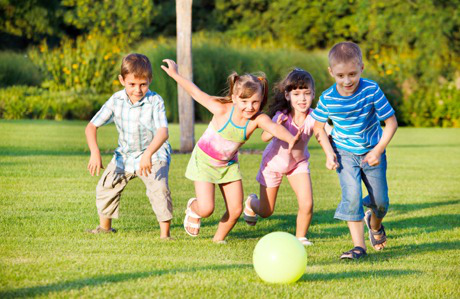

In [23]:
image_file_name = 'images/test/test2.jpeg'
question = u"How is the weather?"
from PIL  import Image
im = Image.open(image_file_name)
im

<center> How is the weather? </center>

In [24]:
image_features = get_image_features(image_file_name, CNN_weights_file_name)

(1, 3, 224, 224)


In [25]:
question_features = get_question_features(question)

In [26]:
y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

97.23 % sunny!
1.32 % cold!
0.37 % clear!
0.18 % green!
0.16 % overcast!


#  URL ile yüklenen resim yoluyla 

Cv2.imread bir resmi URL'den okuyamayacağından, `get_image_features` işlevimizi değiştirmemiz gerekecek.

In [27]:
def get_image_features(image_file_name, CNN_weights_file_name):

    image_features = np.zeros((1, 4096))
        
    from skimage import io

    im = cv2.resize(io.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) 

    im = np.expand_dims(im, axis=0) 

    image_features[0,:] = get_image_model(CNN_weights_file_name).predict(im)[0]
    return image_features

In [28]:
image_file_name = "http://www.newarkhistory.com/indparksoccerkids.jpg"

image_features = get_image_features(image_file_name, CNN_weights_file_name)
image_features.shape

(1, 4096)

<img src="http://www.newarkhistory.com/indparksoccerkids.jpg">
<center> What are they playing? </center>

In [29]:
question = u"What are they playing?"

question_features = get_question_features(question)

In [30]:
y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

55.44 % frisbee!
18.91 % tennis!
16.95 % baseball!
8.31 % soccer!
0.07 % ball!


In [31]:
question = u"Are they playing soccer?"

question_features = get_question_features(question)

<img src="http://www.newarkhistory.com/indparksoccerkids.jpg">
<center> Are they playing soccer? </center>

In [32]:
y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):

    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

57.45 % no!
42.55 % yes!
0.0 % game!
0.0 % playing game!
0.0 % net!


#  Birkaç deneme yapalım.. 

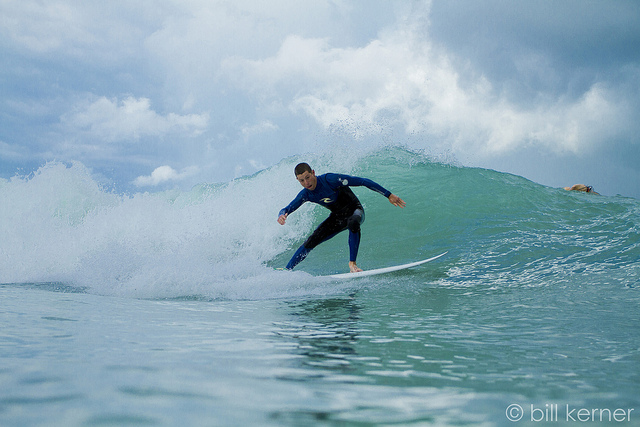

In [34]:
image_file_name = 'images/test/test5.jpg'
question = u"What is done in the picture?"

from PIL  import Image
im = Image.open(image_file_name)
im

In [35]:
image_features = get_image_features(image_file_name, CNN_weights_file_name)
image_features.shape

(1, 4096)

In [36]:
question_features = get_question_features(question)
question_features.shape

(1, 30, 300)

In [37]:
y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

99.43 % surfing!
0.11 % parasailing!
0.05 % water!
0.05 % wetsuit!
0.05 % fish!
